In [496]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from PIL import Image

from keras.models import Model, model_from_json
from keras.datasets import mnist
import keras.backend as K

In [29]:
sns.set_style('white')
sns.set_context('paper', font_scale=2.0, rc={
    'axes.linewidth': 2.0,
    'lines.linewidth': 2.0,
    'font.family': 'Helvetica',
})

In [556]:
with open('data/vae_information_dropout.json', 'r') as f:
    vae = model_from_json(f.readline())
vae.load_weights('data/vae_weights_49_157.69.h5')
print(vae.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (100, 784)            0                                            
____________________________________________________________________________________________________
h (Dense)                        (100, 256)            200960      input[0][0]                      
____________________________________________________________________________________________________
z (Dense)                        (100, 2)              514         h[0][0]                          
____________________________________________________________________________________________________
z_logalpha (Dense)               (100, 2)              514         h[0][0]                          
___________________________________________________________________________________________

In [557]:
encoder = Model(vae.get_layer('input').output, vae.get_layer('z').output, name='encoder')

In [292]:
print(encoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (100, 784)            0                                            
____________________________________________________________________________________________________
h (Dense)                        (100, 256)            200960      input[0][0]                      
____________________________________________________________________________________________________
z (Dense)                        (100, 2)              514         h[0][0]                          
Total params: 201474
____________________________________________________________________________________________________
None


In [406]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [558]:
batch_size = 100
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

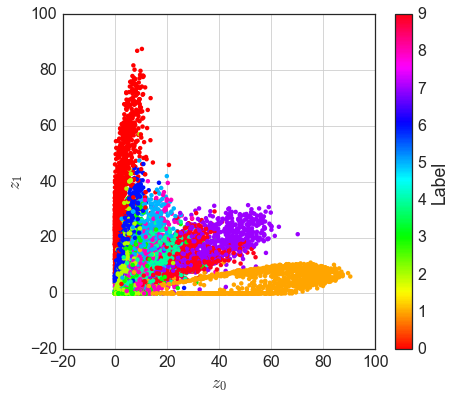

In [559]:
plt.figure(figsize=(7, 6))
plt.scatter(
    x_test_encoded[:, 0], x_test_encoded[:, 1],
    c=y_test, cmap=mpl.cm.hsv, edgecolor='none')
cb = plt.colorbar()
cb.set_label('Label')
plt.grid()
plt.xlabel(r'$z_0$')
plt.ylabel(r'$z_1$')
plt.savefig('images/latent.png', bbox_inches='tight')

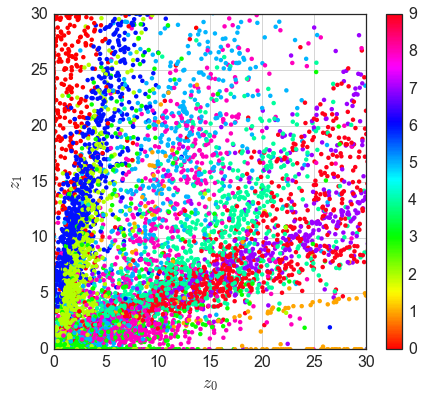

In [560]:
plt.figure(figsize=(7, 6))
plt.scatter(
    x_test_encoded[:, 0], x_test_encoded[:, 1],
    c=y_test, cmap=mpl.cm.hsv, edgecolor='none')
plt.colorbar()
plt.grid()
plt.xlim(-0, 30)
plt.ylim(-0, 30)
plt.xlabel(r'$z_0$')
plt.ylabel(r'$z_1$')
plt.savefig('images/latent_focused.png', bbox_inches='tight')

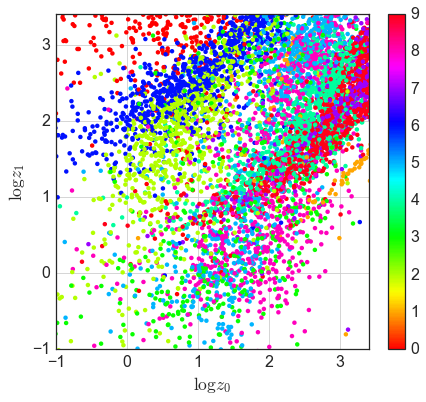

In [561]:
plt.figure(figsize=(7, 6))
plt.scatter(
    np.log(x_test_encoded[:, 0]), np.log(x_test_encoded[:, 1]),
    c=y_test, cmap=mpl.cm.hsv, edgecolor='none')
plt.colorbar()
plt.grid()
plt.xlim(-1, np.log(30.0))
plt.ylim(-1, np.log(30.0))
plt.xticks(np.arange(-1,4,1))
plt.yticks(np.arange(-1,4,1))
plt.xlabel(r'$\log z_0$')
plt.ylabel(r'$\log z_1$')
plt.savefig('images/latent_focused_log.png', bbox_inches='tight')

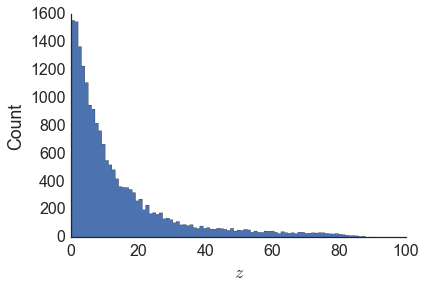

In [562]:
_ = plt.hist(x_test_encoded.flatten(), bins=np.linspace(0.0, 100, 100), histtype='stepfilled')
sns.despine()
plt.xlabel(r'$z$')
plt.ylabel('Count')
plt.savefig('images/activity_histogram.pdf', bbox_inches='tight')

In [563]:
from keras.layers import Input
latent_dim = 2
decoder_input = Input(shape=(latent_dim,))
_h_decoded = vae.get_layer('decoder_h')(decoder_input)
_x_decoded_mean = vae.get_layer('decoder_x')(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [568]:
n = 20  # figure with 15x15 digits
digit_size = 28
padding = 0
CANVAS_SIZE = (
    digit_size*n + padding*(n+1),
    digit_size*n + padding*(n+1)
)

# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
# grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
# grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# grid_x = np.logspace(-3, np.log(30), n)
# grid_y = np.logspace(-3, np.log(20), n)

grid_x = np.linspace(0, 30, n)
grid_y = np.linspace(0, 30, n)

# grid_x = np.linspace(0, x_test_encoded[:, 0].max(), n)
# grid_y = np.linspace(0, x_test_encoded[:, 1].max(), n)

# grid_x = np.logspace(-3, np.log(x_test_encoded[:, 0].max()), n)
# grid_y = np.logspace(-3, np.log(x_test_encoded[:, 1].max()), n)

canvas = Image.new('L', size=CANVAS_SIZE, color='white')
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        img = Image.fromarray(np.uint8(digit*255.), mode='L')
        canvas.paste(
            img, (
                digit_size*i + padding*(i+1),
                digit_size*j + padding*(j+1)
            )
        )


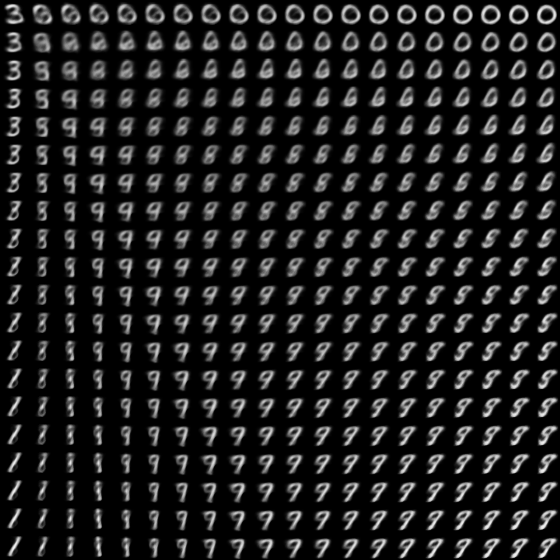

In [569]:
canvas.save('images/generated_image.png')
canvas

In [576]:
n = 20  # figure with 15x15 digits
digit_size = 28
padding = 0
CANVAS_SIZE = (
    digit_size*n + padding*(n+1),
    digit_size*n + padding*(n+1)
)


grid_x = np.logspace(-0.5, np.log(5), n)
grid_y = np.logspace(-0.5, np.log(5), n)

canvas = Image.new('L', size=CANVAS_SIZE, color='white')
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        img = Image.fromarray(np.uint8(digit*255.), mode='L')
        canvas.paste(
            img, (
                digit_size*i + padding*(i+1),
                digit_size*j + padding*(j+1)
            )
        )


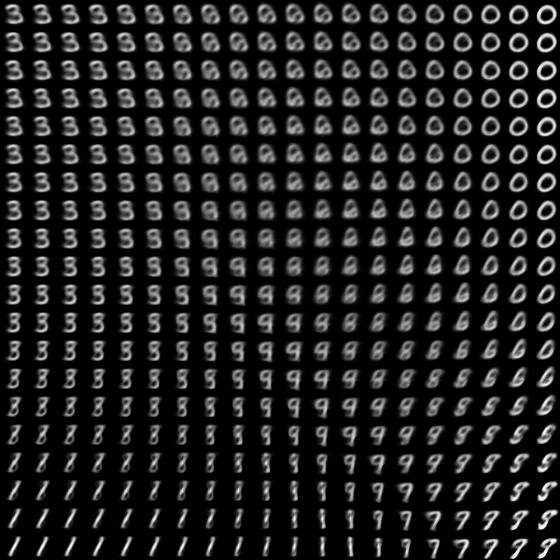

In [577]:
canvas.save('images/generated_image_log.png')
canvas

In [578]:
z_logalpha_eval_model = Model(vae.get_layer('input').output, vae.get_layer('z_logalpha').output, name='encoder')

In [579]:
z_logalpha_test_encoded = z_logalpha_eval_model.predict(x_test, batch_size=batch_size)

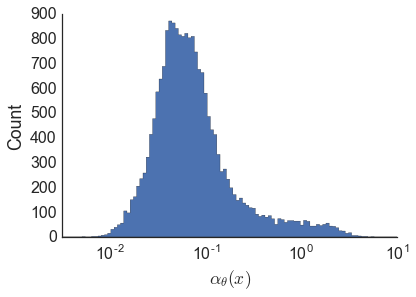

In [586]:
assert np.exp(z_logalpha_test_encoded).max() != 0.0, 'alpha = 0.0'
_ = plt.hist(np.exp(z_logalpha_test_encoded.flatten()), bins=np.logspace(-3, 2, 150),
            histtype='stepfilled')
# _ = plt.hist(np.exp(z_logalpha_test_encoded.flatten()), bins=100,
#             histtype='stepfilled')
plt.xscale('log')
plt.xlim(10**(-2.5), 10**(1))

sns.despine()
plt.xlabel(r'$\alpha_{\theta}(x)$')
plt.ylabel('Count')
plt.savefig('images/dropout_value.pdf', bbox_inches='tight')

In [587]:
weight = K.eval(vae.get_layer('h').W)

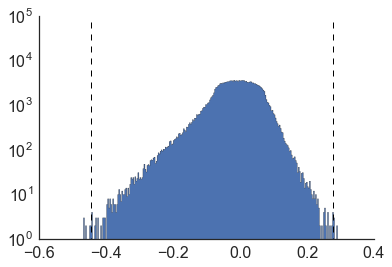

In [590]:
clip = 0.8

_ = plt.hist(weight.flatten(), bins=300, histtype='stepfilled')
plt.plot([weight.min()*clip, weight.min()*clip], [0, 1e5], '--', color='black', lw=1)
plt.plot([weight.max()*clip, weight.max()*clip], [0, 1e5], '--', color='black', lw=1)
sns.despine()
plt.yscale('log')

In [597]:
n = 16
digit_size = 28
padding = 2
CANVAS_SIZE = (
    digit_size*n + padding*(n+1),
    digit_size*n + padding*(n+1)
)
clip = 0.8

weight_forvis = weight - weight.min() * clip
weight_forvis = weight_forvis / (weight_forvis.max() * clip) * 255.

canvas = Image.new('L', size=CANVAS_SIZE, color='white')
for i in range(n):
    for j in range(n):
#         weight_forvis = weight[:, i*n+j].reshape(digit_size, digit_size)
#         weight_forvis -= weight_forvis.min()
#         weight_forvis = weight_forvis / weight_forvis.max() * 255.
#         img = Image.fromarray(np.uint8(weight_forvis), mode='L')
        img = Image.fromarray(np.uint8(weight_forvis[:, i*n+j].reshape(digit_size, digit_size)), mode='L')
        canvas.paste(
            img, (
                digit_size*i + padding*(i+1),
                digit_size*j + padding*(j+1)
            )
        )

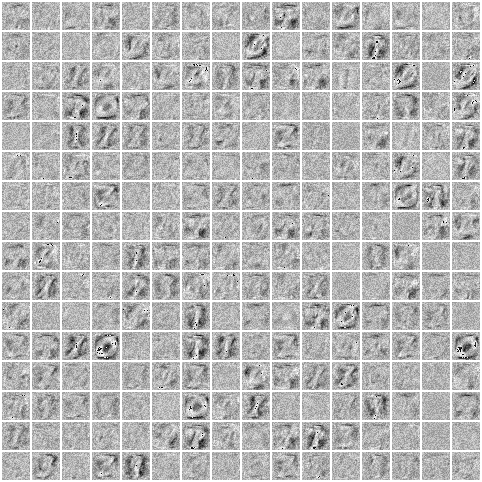

In [598]:
canvas.save('images/weight_diagram.png')
canvas